# Tutorial 4: Hubble Diagram from DES 5YR

<img align="left" src = ../_static/images/logo044.jpg width=120 style="padding: 10px"> 
<br><b>Dark Energy Survey Supernova Program</b>

<b>Tutorial Part 4</b>
<b>Hubble Diagram</b> <br>
Contact author: Maria Vincenzi<br>

In [1]:
from astropy.cosmology import FlatwCDM, Flatw0waCDM
import matplotlib.colors as cols
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/61/jz5zv4qn1ml4kvb_mzhpz5500000gn/T/ipykernel_75412/3990346281.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [86]:
# Point to the Data Release folder

DES5YR_folder = 'GitHub/DES-SN5YR'
HD_path = DES5YR_folder+'4_DISTANCES_COVMAT/DES-SN5YR_HD+MetaData.csv'
HD = pd.read_csv(HD_path,comment='#')


## remove any constant offset from the Hubble residuals
weights = 1./(HD.MUERR_FINAL.values**2)
offset = np.average(HD.MU.values-FlatwCDM_bfit.distmod(HD.zHD.values).value, weights=weights)
HD['myMURES'] = HD.MU.values-FlatwCDM_bfit.distmod(HD.zHD.values).value-offset
HD.drop(labels=['CID'], axis=1, inplace=True)

# Divide DES and non-DES samples 
des5yr= HD[HD.IDSURVEY==10].copy()
lowz= HD[HD.IDSURVEY!=10]

# Set Classification probability column
Prob_column = "PROB_SNNV19"

In [87]:
# Best fit cosmologies as reported in our publications (SN only)

FlatLCDM_bfit = FlatwCDM(Om0=0.352, H0=70)
FlatwCDM_bfit = FlatwCDM(Om0=0.264, H0=70, w0=-0.8)
Flatw0waCDM_bfit = Flatw0waCDM(Om0=0.495, H0=70, w0=-0.36, wa=-8.8)
Planck_bf = FlatwCDM(Om0=0.315, H0=70)


In [88]:
def MU_weighted_average(df_grouped):
    w = 1./df_grouped.MUERR_FINAL.values**2
    avg_,sum_w = np.average(df_grouped.MU.values, weights=w, returned=True)
    return avg_

def MU_weighted_average_err(df_grouped):
    w = 1./df_grouped.MUERR_FINAL.values**2
    avg_,sum_w = np.average(df_grouped.MU.values, weights=w, returned=True)
    avg_err = np.std(df_grouped.MU.values)/np.sqrt(len(df_grouped.MU.values))
    return avg_err

def MURES_weighted_average(df_grouped):
    w = 1./df_grouped.MUERR_FINAL.values**2
    avg_,sum_w = np.average(df_grouped.myMURES.values, weights=w, returned=True)
    return avg_

def MURES_weighted_average_err(df_grouped):
    w = 1./df_grouped.MUERR_FINAL.values**2
    avg_,sum_w = np.average(df_grouped.myMURES.values, weights=w, returned=True)
    avg_err = np.std(df_grouped.myMURES.values)/np.sqrt(len(df_grouped.myMURES.values))
    return avg_err

In [89]:
# Set color maps and marker colors
lowz_color='#D04A07'
des_color='#236CA7'
norm = cols.Normalize(-1,1)
colors = [[norm(-1.0), '#b4d7e8'], [norm( 1.0), '#236CA7']]
mycmap = cols.LinearSegmentedColormap.from_list("", colors)


nitem 57.15625


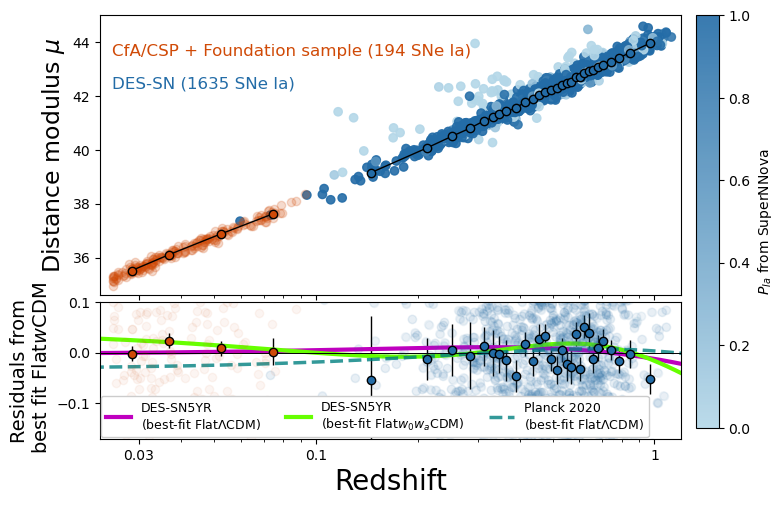

In [95]:
fig=plt.figure(figsize=(7.5,5.5))


###################################
### Hubble Diagram: Upper panel ###
###################################

a1 = plt.subplot2grid((3,1),(0,0),rowspan = 2)
plt.errorbar(des5yr.zHD.values, des5yr.MU.values, fmt='o',
             mfc='None', mec='None', ecolor=des_color, alpha=0.2, zorder=0)
im=plt.scatter(des5yr.zHD.values, des5yr.MU.values, alpha=0.9,
            cmap=mycmap, c=des5yr[Prob_column].values, zorder=1)
plt.errorbar(lowz.zHD.values, lowz.MU.values, fmt='o',
             mfc=lowz_color, mec=lowz_color, ecolor=lowz_color, alpha=0.2)

HD_sorted = HD.sort_values(by='zHD')
nitem = len(HD_sorted)/32
print('nitem', nitem)
HD_sorted['group']=HD_sorted.groupby(np.arange(len(HD_sorted.index))//nitem,axis=0).ngroup()+1

# select equally populated redshift bins 
mask_des = (HD_sorted.IDSURVEY.values==10)&(HD_sorted.zHD.values>0.1)
des_mean_mu = HD_sorted[mask_des].groupby('group').apply(MU_weighted_average).reset_index(name='weighted_average_MU')['weighted_average_MU'].values
des_mean_muerr1 = HD_sorted[mask_des].groupby('group').apply(MU_weighted_average_err).reset_index(name='weighted_average_MUERR')['weighted_average_MUERR'].values
plt.errorbar(HD_sorted[mask_des].groupby('group').mean()['zHD'].values, des_mean_mu, yerr=des_mean_muerr1, fmt='o-', color='k', mfc=des_color, lw=1)

mask_lz = HD_sorted.IDSURVEY.values!=10
low_mean_mu = HD_sorted[mask_lz].groupby('group').apply(MU_weighted_average).reset_index(name='weighted_average_MU')['weighted_average_MU'].values
low_mean_muerr = HD_sorted[mask_lz].groupby('group').apply(MU_weighted_average_err).reset_index(name='weighted_average_MUERR')['weighted_average_MUERR'].values
plt.errorbar(HD_sorted[mask_lz].groupby('group').mean()['zHD'].values, low_mean_mu, yerr=low_mean_muerr, fmt='o-', color='k', mfc=lowz_color, lw=1)

plt.xscale('log')
plt.xlim(0.023, 1.2)

a1.set_ylabel(r'Distance modulus $\mu$',fontsize=17)
plt.xticks([0.03,0.1,1],[' ',' ',' '])
plt.ylim(34.6,45)
plt.text(0.025,43.5, r'CfA/CSP + Foundation sample (%i SNe Ia)'%len(lowz), color=lowz_color, fontsize=12)
plt.text(0.025,42.3, 'DES-SN (%s SNe Ia)'%(len(des5yr)), color=des_color, fontsize=12)

cbar_ax = fig.add_axes([0.92, 0.13, 0.03, 0.75])
fig.colorbar(im, cax=cbar_ax, label=r'$P_{Ia}$ from SuperNNova')


#######################################
### Hubble Residuals (Lowers panel) ###
#######################################

a2 = plt.subplot2grid((3,1),(2,0), rowspan = 1)
plt.errorbar(des5yr.zHD.values, des5yr.myMURES.values, fmt='o',
             mfc=des_color, mec=des_color, ecolor=des_color, alpha=0.05)
im=plt.scatter(des5yr.zHD.values, des5yr.myMURES.values, alpha=0.05,
            cmap=mycmap, c=des5yr[Prob_column].values, zorder=1)
plt.errorbar(lowz.zHD.values, lowz.myMURES.values, fmt='o',
             mfc=lowz_color, mec=lowz_color, ecolor=lowz_color, alpha=0.05)

# select equally populated redshift bins 
mask_des = (HD_sorted.IDSURVEY.values==10)&(HD_sorted.zHD.values>0.1)
des_mean_mu = HD_sorted[mask_des].groupby('group').apply(MURES_weighted_average).reset_index(name='weighted_average_MU')['weighted_average_MU'].values
des_mean_muerr = HD_sorted[mask_des].groupby('group').apply(MURES_weighted_average_err).reset_index(name='weighted_average_MUERR')['weighted_average_MUERR'].values
plt.errorbar(HD_sorted[mask_des].groupby('group').mean()['zHD'].values, des_mean_mu, yerr=des_mean_muerr, fmt='o', color='k', mfc=des_color, lw=1)

mask_lz = HD_sorted.IDSURVEY.values!=10
low_mean_mu = HD_sorted[mask_lz].groupby('group').apply(MURES_weighted_average).reset_index(name='weighted_average_MU')['weighted_average_MU'].values
low_mean_muerr = HD_sorted[mask_lz].groupby('group').apply(MURES_weighted_average_err).reset_index(name='weighted_average_MUERR')['weighted_average_MUERR'].values
plt.errorbar(HD_sorted[mask_lz].groupby('group').mean()['zHD'].values, low_mean_mu, yerr=low_mean_muerr, fmt='o', color='k', mfc=lowz_color, lw=1)

# Plot best fit cosmologies and compare
zz = np.linspace(0.01,1.2,200)
cosmo1_diff = FlatLCDM_bfit.distmod(zz).value-FlatwCDM_bfit.distmod(zz).value
plt.plot(zz, cosmo1_diff-np.mean(cosmo1_diff), '-m', lw=3, label='DES-SN5YR'+"\n"+'(best-fit Flat$\Lambda$CDM)')

cosmo_alternative_diff = Flatw0waCDM_bfit.distmod(zz).value-FlatwCDM_bfit.distmod(zz).value
plt.plot(zz, cosmo_alternative_diff-np.mean(cosmo_alternative_diff), '-', 
         color='#66ff00', lw=3, label='DES-SN5YR'+"\n"+'(best-fit Flat$w_0 w_a$CDM)')

cosmo_alternative_diff = Planck_bf.distmod(zz).value-FlatwCDM_bfit.distmod(zz).value
plt.plot(zz, cosmo_alternative_diff-np.mean(cosmo_alternative_diff), '--',
         color='#008080', lw=2.5, alpha=0.8, label='Planck 2020'+"\n"+'(best-fit Flat$\Lambda$CDM)')


plt.legend(ncol=3, framealpha=1, loc=(0.001,0.01), fontsize=9)
plt.ylim(-0.17,0.1)
plt.hlines(0, 0, 1.2, lw=0.7, linestyle='-', color='k')
plt.xlim(0.023, 1.2)
plt.xscale('log')
a2.set_xlabel('Redshift',fontsize=20)
a2.set_ylabel('Residuals from\n best fit Flat$w$CDM',fontsize=14)
plt.xticks([0.03,0.1,1],['0.03','0.1','1'])
plt.subplots_adjust(hspace=0.05)
#fig.savefig('HD_5yr_KeyPaper.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)